# YOLO v1 

saving model to /content/gdrive/MyDrive/model/yolo/v1/20230319010618/yolo_v1_checkpoint.hdf5
https://stackoverflow.com/questions/71517152/tensorflow-load-checkpoint

# Setup

In [3]:
!pip install python-dateutil datefinder

In [1]:
import os
import sys
import json
import pathlib
from typing import (
    List,
    Dict,
    Tuple
)

import numpy as np
import tensorflow as tf
from tensorflow import keras   # MUST to make sure of using tensorflow.keras, not keras
from tensorflow.keras import (
    backend as K
)
from tensorflow.keras.models import (
    Model,
)
from tensorflow.keras.layers import (
    Layer,
    Normalization,
)
import tensorflow_datasets as tfds

In [2]:
# tf.config.run_functions_eagerly(False)
# tf.data.experimental.enable_debug_mode()

In [3]:
def is_in_colab() -> bool:    
    try:
        # --------------------------------------------------------------------------------
        # Check if the environment is Google Colab.
        # --------------------------------------------------------------------------------
        import google.colab
        IN_GOOGLE_COLAB = True
        print("Using Google Colab environment.")

        # --------------------------------------------------------------------------------
        # Mount Google drive
        # --------------------------------------------------------------------------------
        google.colab.drive.mount('/content/gdrive', force_remount=True)
        
        return True

    except ModuleNotFoundError as e:
        # if str(e) == "No module named 'google.colab'":
        IN_GOOGLE_COLAB = False    
        print("Not using Google Colab environment.")

    return False

## PATH

* PYTHONPATH
* DATA
* LIB

In [4]:
if is_in_colab():
    TFDS_DATA_DIR = "/content/gdrive/MyDrive/data"
    TF_LOG_DIR = "/content/gdrive/MyDrive/log/yolo/v1"
    TF_MODEL_DIR = "/content/gdrive/MyDrive/model/yolo/v1"
    
    LIB_DIR = "/content/gdrive/MyDrive/git/python_programs/lib"
    COLAB_DIR = "/content/gdrive/MyDrive/Colab Notebooks"
    sys.path += [LIB_DIR, COLAB_DIR]
else:
    TFDS_DATA_DIR = "/Volumes/SSD/data/tfds/"
    TF_LOG_DIR = "/Volumes/SSD/data/log/yolo/v1"
    TF_MODEL_DIR = "/Volumes/SSD/data/model/yolo/v1"
    
    LIB_DIR = "../../../../../lib"
    sys.path += [str(pathlib.Path(os.path.join(os.getcwd(), LIB_DIR)).resolve())]

Not using Google Colab environment.


In [44]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from util_file import (
    mkdir
)
from util_datetime import (
    get_datetime_string
)
from util_opencv.image import (
    get_image,
    show_image,
    draw_box_on_image,
    draw_grid
)
from util_tf.nn import (
    train,
    get_early_stopping_callback,
    get_tensorboard_callback,
    get_model_checkpoint_callback,
    get_reduce_lr_callback,
)
from util_tf.tfds.voc import (
    generate_yolo_v1_labels_from_pascal_voc,
    generate_yolo_v1_data_from_pascal_voc,
    PASCAL_VOC_CLASSES,
)

from util_tf.yolo.v1.constant import (
    DEBUG_LEVEL,
    TYPE_FLOAT,
    YOLO_V1_PREDICTION_NUM_CLASSES,
    YOLO_GRID_SIZE,
    YOLO_V1_IMAGE_WIDTH,
    YOLO_V1_IMAGE_HEIGHT,
    YOLO_V1_LABEL_LENGTH,
    YOLO_V1_LABEL_INDEX_CP,
    YOLO_V1_LABEL_INDEX_X,
    YOLO_V1_LABEL_INDEX_Y,
    YOLO_V1_LABEL_INDEX_W,
    YOLO_V1_LABEL_INDEX_H,
    YOLO_V1_PREDICTION_NUM_PRED,
    YOLO_V1_PREDICTION_NUM_CLASSES,
    YOLO_V1_LR_1ST,
    YOLO_V1_EPOCHS_1ST,
    YOLO_V1_LR_2ND,
    YOLO_V1_EPOCHS_2ND,
    YOLO_V1_LR_3RD,
    YOLO_V1_EPOCHS_3RD,
    YOLO_V1_LR_4TH,
    YOLO_V1_EPOCHS_4TH,
)
from util_tf.yolo.v1.model import (
    layers_config,
    input_shape,
    YOLOModel,
)
from util_tf.yolo.v1.loss import (
    YOLOLoss
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constant

In [6]:
DATETIME = get_datetime_string()

In [7]:
S = YOLO_GRID_SIZE
C = YOLO_V1_PREDICTION_NUM_CLASSES
P = YOLO_V1_PREDICTION_NUM_PRED

In [8]:
LOG_DIR = os.path.join(TF_LOG_DIR, DATETIME)
MODEL_DIR = os.path.join(TF_MODEL_DIR, DATETIME)

mkdir(LOG_DIR)
mkdir(MODEL_DIR)

---
# Data

## TFDS PASCAL VOC

In [9]:
voc, info = tfds.load(
    name='voc', 
    data_dir=TFDS_DATA_DIR,
    with_info=True,
)
info

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='/Volumes/SSD/data/tfds/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868

## YOLO v1 dataset

Dataset in ```(input,label)``` format where input is ```(448,448,3)``` RGB image and label is YOLO v1 label in ```(C,P)``` format where ```P=(cp,x,y,w,h)```.

In [10]:
train = voc['train'].map(generate_yolo_v1_data_from_pascal_voc)
validation = voc['validation'].map(generate_yolo_v1_data_from_pascal_voc)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Input Image

2023-03-19 11:26:52.586182: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(448, 448, 3)


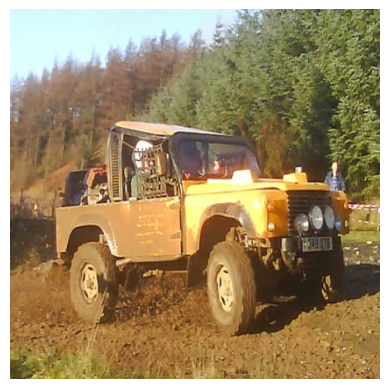

In [11]:
num_shards: int = 100
record = next(
    train\
        .shard(num_shards=num_shards, index=np.random.randint(0,num_shards))\
        .shuffle(128)\
        .as_numpy_iterator()
)
image = record[0]
label = record[1]

print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

### Label

In [12]:
_labels: List[str] = []
_boxes: List[Tuple] = []
    
for id, cell in enumerate(label.reshape((-1, C+P))):
    cp = cell[YOLO_V1_LABEL_INDEX_CP]
    if cp == 1:
        _coordinate = (int(id / S), int(id % S))
        _label = PASCAL_VOC_CLASSES[np.argmax(cell[:YOLO_V1_PREDICTION_NUM_CLASSES]==1)]
        _box = cell[YOLO_V1_LABEL_INDEX_X:YOLO_V1_LABEL_INDEX_H+1]
        msg = "{} {}".format(
            _coordinate,
            _label
        )
        print(msg)
        _labels.append(msg)
        _boxes.append(_box)


(3, 6) person
(4, 3) car


### Bounding Boxes

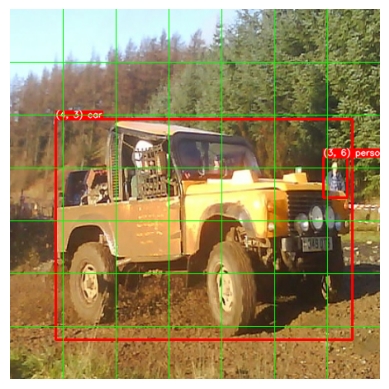

In [13]:
_image = image.copy()
for label, box in zip(_labels, _boxes):
    _image = draw_box_on_image(img=_image, bbox=box, title=label)
    _image = draw_grid(img=_image, shape=(S,S))
    show_image(image=_image, bgr_to_rgb=False)

In [14]:
def validate(image, label):
    tf.debugging.assert_all_finite(x=image, message="expected record is finite")
    tf.debugging.assert_all_finite(x=label, message="expected record is finite")

    return 1

In [15]:
_ = train.map(validate)
del _

_ = validation.map(validate)
del _

---

# Model

<img src="../image/architecture.png" align="left"/>


* yolo.cfg

```
[net]
batch=64
subdivisions=64
height=448
width=448
channels=3
momentum=0.9
decay=0.0005

learning_rate=0.001
policy=steps
steps=200,400,600,20000,30000
scales=2.5,2,2,.1,.1
max_batches = 40000

[crop]
crop_width=448
crop_height=448
flip=0
angle=0
saturation = 1.5
exposure = 1.5

[convolutional]
filters=64
size=7
stride=2
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=192
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=128
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[maxpool]
size=2
stride=2

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

[convolutional]
filters=512
size=1
stride=1
pad=1
activation=leaky

[convolutional]
filters=1024
size=3
stride=1
pad=1
activation=leaky

#######

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=2
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[convolutional]
size=3
stride=1
pad=1
filters=1024
activation=leaky

[connected]
output=4096
activation=leaky

[dropout]
probability=.5

[connected]
output= 1470
activation=linear

[detection]
classes=20
coords=4
rescore=1
side=7
num=2
softmax=0
sqrt=1
jitter=.2

object_scale=1
noobject_scale=.5
class_scale=1
coord_scale=5
```

In [16]:
input_shape

(448, 448, 3)

In [17]:
model: Model = YOLOModel()

Model: "yolo_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 448, 448, 3)]     0         
                                                                 
 norm (Normalization)        (None, 448, 448, 3)       7         
                                                                 
 conv01 (Conv2D)             (None, 224, 224, 64)      9472      
                                                                 
 act01 (LeakyReLU)           (None, 224, 224, 64)      0         
                                                                 
 maxpool01 (MaxPooling2D)    (None, 112, 112, 64)      0         
                                                                 
 conv02 (Conv2D)             (None, 112, 112, 192)     110784    
                                                                 
 act02 (LeakyReLU)           (None, 112, 112, 192)     0   

In [18]:
image, labeel = next(train.take(1).as_numpy_iterator())
image.shape
assert np.all(np.isfinite(model.model(image.reshape((1,448,448,3)).astype(np.uint8))))

---
# Normalize

The model includes a Normalization layer as the first layer. Fit the layer to the sample data. No need to use entire data to fit but adequate samples will suffice. Hence use ```shard(num_shard=10)``` to only use 1/10 of the data.

In [19]:
norm: Layer = model.get_layer(name="norm")
for weight in norm.weights:
    print(weight.name, weight.numpy())

norm/mean:0 [0. 0. 0.]
norm/variance:0 [1. 1. 1.]
norm/count:0 0


In [20]:
norm.axis   # standardize along axis=-1 (depth wise standardization where each pixel is a feature)

(-1,)

In [21]:
def extract_input(image, label):
    """Take input image from (input, label) data"""
    return image

def extract_label(image, label):
    """Take label from (input, label) data"""
    return label

In [22]:
samples = train\
    .shuffle(buffer_size=128)\
    .prefetch(buffer_size=tf.data.AUTOTUNE)\
    .shard(num_shards=10, index=0)\
    .shuffle(buffer_size=128)\
    .map(extract_input)

In [23]:
norm.adapt(samples)

## Verification

### Normalization Layer Weights

Make sure the normalization layer has been adapted.

In [24]:
for weight in norm.weights:
    print(weight.name, weight.numpy())

norm/mean:0 [105.296326 105.296326 105.296326]
norm/variance:0 [4981.42 4981.42 4981.42]
norm/count:0 151130112


### Staandization and Restoration

Make sure the Normalization layer standardize the image that can be restored via $x = standardized(x) * std(x) + \hat{x}$.

(448, 448, 3)


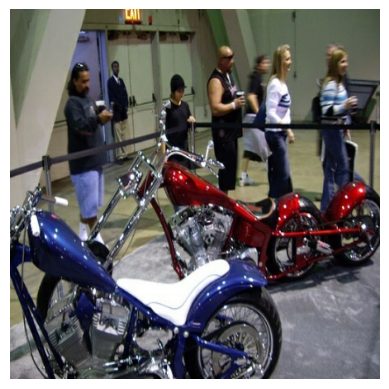

In [25]:
image = next(samples.take(1).as_numpy_iterator())
print(image.shape)
show_image(image=image.astype(np.uint8), bgr_to_rgb=False)

In [26]:
norm(image).numpy().mean()

-0.22202283

In [27]:
norm(image).shape

TensorShape([1, 448, 448, 3])

In [28]:
model.get_layer(name="norm")(image).numpy().mean()

-0.22202283

Verify restored image via $x = standardized(x) * std(x) + \hat{x}$ .

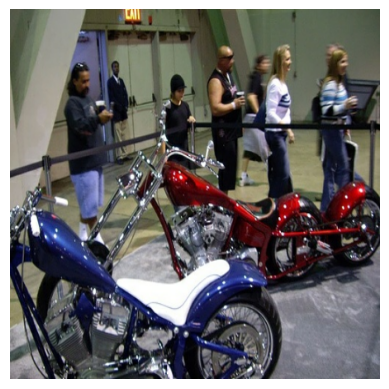

In [29]:
restored = norm(image).numpy().squeeze() * np.sqrt(norm.variance.numpy().squeeze()) + norm.mean.numpy().squeeze()
show_image(image=restored.astype(np.uint8), bgr_to_rgb=False)

---
# Model Validation

Make sure the model output is **NOT nan nor inf**.

In [30]:
pos = 0
for image in samples.shard(num_shards=10, index=0).as_numpy_iterator():
    output = model.model(image.reshape(-1, 448, 448, 3))
    if pos % 1000 == 0:
        print(pos)
        
    if not np.all(np.isfinite(output.numpy())):
        print(pos)
        print(output)
    
    tf.debugging.assert_all_finite(x=output, message="expected finite")
    pos += 1
    
print(pos)

0
26


In [31]:
del voc
del samples

---
# Training

### Tensorboard callback

In [32]:
tensorboard_callback = get_tensorboard_callback(
    log_dir=LOG_DIR,
    write_graph=True,
    write_images=True,
    histogram_freq=1,  # How often to log histogram visualizations
    embeddings_freq=1  # How often to log embedding visualizations
)

### Early stop callback

In [33]:
earlystop_callback = get_early_stopping_callback(
    monitor='val_loss', 
    mode='min',
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

### Model checkpoint callback

In [34]:
checkpoint_callback = get_model_checkpoint_callback(
    filepath=os.path.join(MODEL_DIR, 'yolo_v1_checkpoint.hdf5'),
    monitor="val_loss",
    mode="min",
    save_freq='epoch',
    verbose=1
)

### Reduce LR callback

In [35]:
recucelr_callback = get_reduce_lr_callback(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='min',
)

## Run

> We train the network for about 135 epochs on the training and validation data sets
from PASCAL VOC 2007 and 2012. When testing on 2012 we also include the VOC 2007
test data for training.
> 
> Throughout training, we use a batch size of 64, a momentum of 0:9 and a decay of 0:0005.
> 
> Our learning rate schedule is as follows: For the first epochs we slowly raise the
learning rate from 10^-3 (1e-3) to 10^-2 (1e-2). If we start at a high learning rate
our model often diverges due to unstable gradients. We continue training with 10^-2
for 75 epochs, then 10^-3 for 30 epochs, and finally 10^4 (1e-4) for 30 epochs.


In [36]:
BATCH_SIZE = 32
VERBOSE = 1
# Used for generator or keras.utils.Sequence input only
USE_MULTIPROCESSING = None
WORKERS = None

In [37]:
train = train.shuffle(
    buffer_size=128
).batch(
    batch_size=BATCH_SIZE,
    num_parallel_calls=tf.data.AUTOTUNE,
    drop_remainder=True
).prefetch(
    buffer_size=1
)

In [38]:
validation = validation.shuffle(
    buffer_size=128
).batch(
    batch_size=BATCH_SIZE,
    num_parallel_calls=tf.data.AUTOTUNE,
    drop_remainder=True
).prefetch(
    buffer_size=1
)

In [39]:
callbacks=[
    tensorboard_callback,
    earlystop_callback,
    checkpoint_callback,
    recucelr_callback
]

Run in one-go

In [40]:
print(f"learning rate: {model.learning_rate}")

history = model.fit(
    x=train,
    shuffle=True,
    epochs=100,
    validation_data=validation,
    use_multiprocessing=USE_MULTIPROCESSING,
    workers=WORKERS,
    verbose=VERBOSE,
    callbacks=callbacks
)

## Save Model

* [Save and load Keras models - Custom objects](https://www.tensorflow.org/guide/keras/save_and_serialize#custom_objects)

> In order to save/load a model with custom-defined layers, or a subclassed model, you should overwrite the get_config and optionally from_config methods. Additionally, you should use **register the custom object** so that Keras is aware of it.

In [49]:
model.save(os.path.join(MODEL_DIR, "yolo_v1_model"))

INFO:tensorflow:Assets written to: /Volumes/SSD/data/model/yolo/v1/20230319112651/yolo_v1_model/assets


INFO:tensorflow:Assets written to: /Volumes/SSD/data/model/yolo/v1/20230319112651/yolo_v1_model/assets


1/1 [==============================] - 0s 286ms/step


In [50]:
# test model restoration
dummy = keras.models.load_model(
    os.path.join(MODEL_DIR, "yolo_v1_model"), 
    custom_objects={"YOLOLoss": YOLOLoss()}
)
_predict = dummy.predict(image.reshape((1,448,448,3)))
_predict.shape
del dummy

1/1 [==============================] - 0s 258ms/step


# Prediction

In [ ]:
prediction = model.model.predict(image.reshape(1,448,448,3))
prediciton = prediction.reshape((-1,30))

In [ ]:
label = prediction[..., :25]
label.shape

In [ ]:
_labels: List[str] = []
_boxes: List[Tuple] = []
    
for id, cell in enumerate(label.reshape((-1, C+P))):
    cp = cell[YOLO_V1_LABEL_INDEX_CP]
    if cp > 0.7:
        _coordinate = (int(id / S), int(id % S))
        _label = PASCAL_VOC_CLASSES[np.argmax(cell[:YOLO_V1_PREDICTION_NUM_CLASSES] > 0.7)]
        _box = cell[YOLO_V1_LABEL_INDEX_X:YOLO_V1_LABEL_INDEX_H+1]
        msg = "{} {}".format(
            _coordinate,
            _label
        )
        print(msg)
        _labels.append(msg)
        _boxes.append(_box)


In [ ]:
_image = image
for label, box in zip(_labels, _boxes):
    _image = draw_box_on_image(img=_image, bbox=box, title=label)
    _image = draw_grid(img=_image, shape=(S,S))
    show_image(image=_image, bgr_to_rgb=False)